## Investigating Spatial Autocorrelation (EDA-driven introduction)

The exploratory analysis revealed clear spatial patterns in both residential land prices and public transport accessibility. 

Scatter plots and their spatial counterparts indicated regime-like behaviour, while maps of accessibility measures showed coherent corridors, gradients, and node-based structures aligned with transport networks and historical development. 

These observations suggest that values are not spatially independent, but instead influenced by their geographic context.

To formally assess whether the spatial patterns identified in the exploratory analysis reflect statistically significant spatial dependence rather than visual artefacts, spatial autocorrelation analysis is introduced at this stage. 

This step serves as a diagnostic check of the independence assumption underlying standard regression models and determines whether spatially explicit modelling approaches are required.

Spatial autocorrelation measures the degree to which nearby observations exhibit similar or dissimilar values. 

Positive spatial autocorrelation indicates clustering of similar values, while negative spatial autocorrelation reflects spatial dispersion. 

Two complementary perspectives are considered: global measures, which assess overall clustering across the study area, and local measures, which identify specific clusters and spatial outliers. 

Together, these analyses provide a formal link between the exploratory findings and the subsequent choice of modelling framework.

### Global Spatial Autocorrelation

Following the exploratory identification of spatial patterns, the first step is to assess whether these patterns are present at the scale of the study area as a whole. 

Global spatial autocorrelation analysis provides a formal test of whether similar values tend to cluster across the entire city, or whether the observed spatial arrangement could plausibly arise under spatial randomness. 

This global perspective establishes whether spatial dependence is a systemic property of the data, rather than a purely local phenomenon.

To evaluate global spatial dependence, Moran’s I statistic is employed. 

This measure quantifies the degree to which values observed at neighbouring locations are correlated, producing a single summary statistic for the entire study area. 

Positive values of Moran’s I indicate clustering of similar values, values close to zero suggest spatial randomness, and negative values imply spatial dispersion. 

Statistical significance is assessed via permutation testing, allowing the observed statistic to be compared against a null hypothesis of spatial independence.

Applying Moran’s I at this stage serves two purposes. First, it formally confirms whether the spatial structures suggested by the exploratory maps and scatter plots are statistically significant. 

Second, it provides a necessary diagnostic for subsequent modelling, as significant global spatial autocorrelation would violate the independence assumption of standard regression models and motivate the use of spatially explicit approaches.

#### Loading the dataset

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np

DATA_DIR = "data/processed"
PRICE_PATH = f"{DATA_DIR}/price_residential_prague_nearest_stops_by_mode.gpkg"

price = gpd.read_file(PRICE_PATH)

print(price.columns)
print(len(price))


Index(['CENA', 'price_area', 'res_share', 'nearest_tram_id', 'dist_tram_m',
       'nearest_metro_id', 'dist_metro_m', 'nearest_bus_id', 'dist_bus_m',
       'nearest_rail_id', 'dist_rail_m', 'geometry'],
      dtype='str')
5728


#### Preparing numeric variables for Moran test

In [4]:
# Convert price to numeric (string → float), invalid → NaN
price["CENA_num"] = pd.to_numeric(price["CENA"], errors="coerce")

# Log-transform (only valid values)
price["log_price"] = np.log(price["CENA_num"])


In [7]:
#Ensure distances are numeric and in logarithmic scale
DIST_COLS = [
    "dist_tram_m",
    "dist_metro_m",
    "dist_bus_m",
    "dist_rail_m"
]

for col in DIST_COLS:
    price[col] = pd.to_numeric(price[col], errors="coerce")
    price[f"log_{col}"] = np.log(price[col])


#### Spatial weights specification (Queen contiguity)

The identification of spatial autocorrelation requires an explicit definition of spatial relationships between observations. 

This is achieved through the construction of a spatial weights matrix, which formalises the notion of neighbourhood and determines which spatial units are considered to be related. 

In this analysis, a contiguity-based approach is adopted, where two polygons are defined as neighbours if they share a common boundary or vertex.

Queen contiguity is selected as the spatial weighting scheme because it is well suited for polygon-based urban data and captures both edge- and corner-based adjacency. 

Unlike distance-based or k-nearest-neighbour weights, contiguity weights respect the actual spatial partition of the city and avoid imposing an arbitrary distance threshold. 

This is particularly appropriate in a dense urban environment, where administrative and morphological boundaries often play a role in shaping spatial dependence.

The resulting spatial weights matrix encodes the neighbourhood structure of the study area and is row-standardised so that each observation’s influence is relative to its local context. 

This matrix serves as a fundamental input for subsequent spatial analyses: it is used to compute global and local measures of spatial autocorrelation, to generate spatially lagged variables, and to diagnose violations of the independence assumption underlying standard regression models. 

By establishing the spatial interaction structure at this stage, the analysis ensures that later modelling steps explicitly account for spatial dependence rather than treating it as unobserved noise.

In [8]:
from libpysal.weights import Queen

# Drop rows without geometry just in case
price = price[~price.geometry.isna()].copy()
w = Queen.from_dataframe(price, use_index=True)
w.transform = "r"


('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 54, ' is an island (no neighbors)')
('WARNING: ', 64, ' is an island (no neighbors)')
('WARNING: ', 79, ' is an island (no neighbors)')
('WARNING: ', 80, ' is an island (no neighbors)')
('WARNING: ', 83, ' is an island (no neighbors)')
('WARNING: ', 91, ' is an island (no neighbors)')
('WARNING: ', 92, ' is an island (no neighbors)')
('WARNING: ', 100, ' is an island (no neighbors)')
('WARNING: ', 101, ' is an island (no neighbors)')
('WARNING: ', 102, ' is an island (no neighbors)')
('WARNING: ', 103, ' is an island (no neighbors)')
('WARNING: ', 104, ' is an island (no neighbors)')
('WARNING: ', 113, ' is an island (no neighbors)')
('WARNING: ', 120, ' is an island (no neighbors)')
('WARNING: ', 130, ' is an island (no neighbors)')
('WARNING: ', 157, ' is an island (no neighbors)')
('WARNING: ', 186, ' is an island (no neighbors)')
('WARNING: ', 212, ' is an island (no nei

C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 817 disconnected components.
 There are 419 islands with ids: 7, 13, 54, 64, 79, 80, 83, 91, 92, 100, 101, 102, 103, 104, 113, 120, 130, 157, 186, 212, 244, 263, 270, 278, 279, 280, 287, 294, 298, 309, 333, 340, 341, 367, 368, 369, 370, 371, 374, 375, 376, 377, 378, 382, 396, 422, 439, 447, 449, 458, 460, 463, 468, 478, 483, 485, 492, 522, 530, 550, 556, 578, 579, 589, 590, 591, 595, 596, 597, 603, 615, 616, 620, 622, 623, 630, 651, 663, 664, 694, 721, 759, 787, 803, 805, 861, 865, 875, 902, 931, 973, 987, 1001, 1003, 1116, 1117, 1118, 1143, 1158, 1184, 1186, 1190, 1199, 1220, 1222, 1230, 1234, 1241, 1243, 1264, 1293, 1301, 1306, 1308, 1318, 1330, 1347, 1351, 1357, 1359, 1361, 1368, 1376, 1393, 1403, 1404, 1412, 1413, 1431, 1451, 1460, 1470, 1488, 1519, 1523, 1534, 1538, 1557, 1618, 1620, 1623, 1659, 1686, 1687, 1688, 1689, 1

“Contiguity-based Queen weights are appropriate for areal units that form a continuous partition of space. 

In our dataset, the polygon layer contains a large number of disconnected components and isolated units (‘islands’), which makes contiguity weights unsuitable for global and local autocorrelation statistics.

Therefore, distance-based k-nearest-neighbour weights are used to ensure that each observation has a well-defined spatial context and that spatial lag terms are consistently defined across the study area.”

In [9]:
from libpysal.weights import KNN

# centroidy (v projected CRS, ideálně EPSG:5514, aby vzdálenosti dávaly smysl v metrech)
price = price.to_crs("EPSG:5514")

w = KNN.from_dataframe(price, k=8, use_index=True)  # k=6..12 typicky OK, 8 je safe default
w.transform = "r"

print("KNN: islands:", len(w.islands))


KNN: islands: 0


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights ensure every observation has a defined neighbourhood; however, the weights graph is not fully connected due to a small number of spatially isolated polygon groups.

In [13]:
import pandas as pd

print("Number of components:", w.n_components)
print("Number of islands:", len(w.islands))


Number of components: 8
Number of islands: 0


In [14]:
# component label for each observation
labels = pd.Series(w.component_labels)

component_sizes = labels.value_counts().sort_values(ascending=False)
component_sizes

0    5542
4      76
7      30
2      23
6      17
5      15
1      13
3      12
Name: count, dtype: int64

Initial contiguity-based spatial weights (Queen criterion) resulted in a large number of isolated polygons due to the fragmented nature of the spatial units.

To ensure that each observation has a well-defined neighbourhood, k-nearest neighbour (KNN) weights were adopted instead. 

KNN weights guarantee a fixed number of neighbours for every spatial unit and are commonly used in urban analyses where administrative polygons do not form a perfectly contiguous tessellation. 

Although the resulting weights graph is not fully connected and consists of several disconnected components, the dominant component contains the vast majority of observations, allowing robust estimation of global spatial autocorrelation statistics.

#### Computing Global Moran

In [15]:
import numpy as np
import pandas as pd

# ensure projected CRS (already done, but keep explicit)
price = price.to_crs("EPSG:5514")

# price -> numeric + log
price["CENA_num"] = pd.to_numeric(price["CENA"], errors="coerce")
price["log_price"] = np.log(price["CENA_num"])

# distances -> numeric + log
DIST_COLS = [
    "dist_tram_m",
    "dist_metro_m",
    "dist_bus_m",
    "dist_rail_m"
]

for col in DIST_COLS:
    price[col] = pd.to_numeric(price[col], errors="coerce")
    price[f"log_{col}"] = np.log(price[col])


In [16]:
from libpysal.weights import KNN

w = KNN.from_dataframe(price, k=8, use_index=True)
w.transform = "r"

print("Number of components:", w.n_components)
print("Number of islands:", len(w.islands))


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Number of components: 8
Number of islands: 0


In [18]:
from libpysal.weights import KNN
from esda.moran import Moran
import numpy as np

def global_moran(gdf, column, k=8, permutations=999):
    """
    Compute Global Moran's I for a given column.
    Handles NaNs by subsetting data and rebuilding weights.
    """
    # drop NaNs
    gdf_valid = gdf[[column, "geometry"]].dropna()

    # values
    x = gdf_valid[column].values

    # rebuild weights for the subset
    w = KNN.from_dataframe(gdf_valid, k=k, use_index=True)
    w.transform = "r"

    moran = Moran(x, w, permutations=permutations)

    return moran


In [42]:
import numpy as np
import pandas as pd
from libpysal.weights import KNN
from esda.moran import Moran

# --- příprava proměnných (price je GeoDataFrame) ---
price = price.to_crs("EPSG:5514")

price["CENA_num"] = pd.to_numeric(price["CENA"], errors="coerce")
price.loc[price["CENA_num"] <= 0, "CENA_num"] = np.nan
price["log_price"] = np.log(price["CENA_num"])

if "price_area" not in price.columns:
    price["price_area"] = price.geometry.area  # m^2 v EPSG:5514
price.loc[price["price_area"] <= 0, "price_area"] = np.nan
price["log_area"] = np.log(price["price_area"])

MORAN_VARS = [
    ("log_price", "Price (log)"),
    ("price_area", "Area"),
    ("log_area", "Area (log)"),
    ("dist_bus_m", "Bus distance"),
    ("dist_metro_m", "Metro distance"),
    ("dist_tram_m", "Tram distance"),
    ("dist_rail_m", "Rail distance"),
]

K = 8
PERM = 999

results = []
for col, label in MORAN_VARS:
    x = pd.to_numeric(price[col], errors="coerce").values
    mask = np.isfinite(x)

    # subset GeoDF jen pro validní hodnoty
    g = price.loc[mask].copy()

    # build KNN weights na tomhle subsetu (žádný mismatch)
    w_sub = KNN.from_dataframe(g, k=K, use_index=True)
    w_sub.transform = "r"

    moran = Moran(g[col].values.astype(float), w_sub, permutations=PERM)

    results.append({
        "Variable": label,
        "n": int(mask.sum()),
        "Moran I": moran.I,
        "Expected I": moran.EI,
        "p-value": moran.p_sim,
        "disconnected_components": getattr(w_sub, "n_components", None)  # někdy není
    })

moran_table = (
    pd.DataFrame(results)
      .sort_values("Moran I", ascending=False)
)

print(moran_table.to_string(index=False, float_format=lambda v: f"{v:.3f}"))


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Vilem\anaconda3\envs\pr

      Variable    n  Moran I  Expected I  p-value  disconnected_components
Metro distance 5728    0.995      -0.000    0.001                        8
 Tram distance 5728    0.994      -0.000    0.001                        8
 Rail distance 5728    0.978      -0.000    0.001                        8
  Bus distance 5728    0.513      -0.000    0.001                        8
   Price (log) 4871    0.391      -0.000    0.001                        8
    Area (log) 5728    0.030      -0.000    0.001                        8
          Area 5728    0.017      -0.000    0.005                        8


In [43]:
moran_table_round = moran_table.copy()
moran_table_round["Moran I"] = moran_table_round["Moran I"].round(3)
moran_table_round["Expected I"] = moran_table_round["Expected I"].round(3)
moran_table_round["p-value"] = moran_table_round["p-value"].apply(
    lambda x: "< 0.001" if x < 0.001 else round(x, 3)
)

print(moran_table_round.to_string(index=False))

      Variable    n  Moran I  Expected I  p-value  disconnected_components
Metro distance 5728    0.995        -0.0    0.001                        8
 Tram distance 5728    0.994        -0.0    0.001                        8
 Rail distance 5728    0.978        -0.0    0.001                        8
  Bus distance 5728    0.513        -0.0    0.001                        8
   Price (log) 4871    0.391        -0.0    0.001                        8
    Area (log) 5728    0.030        -0.0    0.001                        8
          Area 5728    0.017        -0.0    0.005                        8


Observations with missing values were removed prior to the computation of spatial autocorrelation statistics. 

Spatial weights were subsequently reconstructed on the reduced dataset to ensure consistency between the attribute vector and the weights matrix

The results of the Global Moran’s I test confirm the presence of statistically significant positive spatial autocorrelation for all analysed variables. Residential land price exhibits moderate spatial clustering (Moran’s I = 0.391), indicating that areas with similar price levels tend to be geographically proximate, though the clustering is less pronounced than for accessibility measures. 

In contrast, distance-based variables—particularly metro, tram, and rail distances—show extremely strong spatial autocorrelation (Moran’s I > 0.94), reflecting the highly structured, network-driven nature of public transport infrastructure. 

Bus distance displays weaker, yet still significant, spatial dependence (Moran’s I = 0.323), consistent with its role as a dense, coverage-oriented mode rather than a hierarchical network. 

Overall, these results statistically validate the spatial patterns identified in the exploratory analysis and clearly indicate that spatial dependence is a fundamental property of both prices and accessibility, motivating the subsequent use of local spatial diagnostics and spatially explicit regression models.

While the Global Moran’s I statistics confirm the existence of spatial autocorrelation at the city-wide level, they do not provide information about the spatial location or structure of individual clusters. 

Global measures summarize spatial dependence with a single value and therefore mask local heterogeneity. 

To identify where statistically significant clusters and spatial outliers occur, and to distinguish between different local spatial regimes, a local spatial autocorrelation analysis is conducted in the following section.

This step allows the global patterns identified above to be decomposed into locally meaningful spatial structures

## Local Spatial Autocorrelation

Local spatial autocorrelation analysis extends the global perspective by examining how each individual spatial unit relates to its immediate neighbourhood. 

While global statistics indicate whether spatial dependence exists overall, local measures identify where significant clusters and spatial outliers are located and how they are structured.

Local Moran’s I (LISA) decomposes global spatial autocorrelation into location-specific contributions, allowing the identification of four characteristic spatial association types: high values surrounded by high values (high–high), low values surrounded by low values (low–low), and two types of spatial outliers (high–low and low–high).

This makes it possible to distinguish between coherent spatial regimes and transitional or anomalous areas within the city.

In the context of this study, local spatial autocorrelation is used to reveal how residential land prices and accessibility measures cluster across space, providing insight into underlying urban structure and supporting the interpretation of subsequent spatial regression res

#### Local Moran (LISA) helper function

In [22]:
import numpy as np
import pandas as pd

from libpysal.weights import KNN
from esda.moran import Moran_Local

def lisa_local_moran(
    gdf,
    column,
    k=8,
    permutations=999,
    alpha=0.05,
):
    """
    Compute Local Moran's I (LISA) for a given column.
    Returns a GeoDataFrame subset with LISA statistics and cluster labels.
    """

    # Keep only valid observations
    gdf_valid = gdf[[column, "geometry"]].dropna().copy()

    # Build KNN weights on the valid subset
    w = KNN.from_dataframe(gdf_valid, k=k, use_index=True)
    w.transform = "r"

    x = gdf_valid[column].values

    # Local Moran
    lisa = Moran_Local(x, w, permutations=permutations)

    # Significance mask
    sig = lisa.p_sim < alpha

    # Quadrants: 1=HH, 2=LH, 3=LL, 4=HL (esda convention)
    q = lisa.q

    # Build readable cluster labels
    cluster = np.full(len(gdf_valid), "Not significant", dtype=object)
    cluster[(sig) & (q == 1)] = "High-High"
    cluster[(sig) & (q == 2)] = "Low-High"
    cluster[(sig) & (q == 3)] = "Low-Low"
    cluster[(sig) & (q == 4)] = "High-Low"

    # Attach outputs
    gdf_valid[f"lisa_I_{column}"] = lisa.Is
    gdf_valid[f"lisa_p_{column}"] = lisa.p_sim
    gdf_valid[f"lisa_q_{column}"] = q
    gdf_valid[f"lisa_sig_{column}"] = sig
    gdf_valid[f"lisa_cluster_{column}"] = cluster

    return gdf_valid


##### Calculating Local Moran I Statistics 

In [46]:
LISA_VARS = {
    "price": "log_price",
    "area" : "log_area",
    "bus": "log_dist_bus_m",
    "metro": "log_dist_metro_m",
    "tram": "log_dist_tram_m",
    "rail": "log_dist_rail_m"
}

lisa_results = {}

for name, col in LISA_VARS.items():
    lisa_gdf = lisa_local_moran(price, col, k=8, permutations=999, alpha=0.05)
    lisa_results[name] = lisa_gdf
    print(name, "rows used:", len(lisa_gdf))


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


price rows used: 4871


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


area rows used: 5728


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


bus rows used: 5728


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


metro rows used: 5728


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


tram rows used: 5728


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


rail rows used: 5728


In [47]:
for name, g in lisa_results.items():
    col = LISA_VARS[name]
    print("\n", name.upper())
    print(g[f"lisa_cluster_{col}"].value_counts())


 PRICE
lisa_cluster_log_price
Not significant    3181
High-High           796
Low-Low             612
High-Low            226
Low-High             56
Name: count, dtype: int64

 AREA
lisa_cluster_log_area
Not significant    5037
Low-Low             246
High-High           168
High-Low            159
Low-High            118
Name: count, dtype: int64

 BUS
lisa_cluster_log_dist_bus_m
Not significant    4264
High-High           628
Low-Low             577
High-Low            234
Low-High             25
Name: count, dtype: int64

 METRO
lisa_cluster_log_dist_metro_m
Not significant    2158
High-High          1843
Low-Low            1727
Name: count, dtype: int64

 TRAM
lisa_cluster_log_dist_tram_m
High-High          1957
Low-Low            1905
Not significant    1866
Name: count, dtype: int64

 RAIL
lisa_cluster_log_dist_rail_m
Not significant    2822
High-High          1592
Low-Low            1313
High-Low              1
Name: count, dtype: int64


Local Moran’s I confirms that both residential land prices and accessibility measures form distinct local spatial regimes.

Rail-based modes (metro, tram, rail) are dominated by coherent high–high and low–low clusters, reflecting strong network-driven spatial structure, while bus distance shows weaker and more fragmented clustering consistent with its coverage-oriented role. 

The presence of spatial outliers at regime boundaries highlights local discontinuities that cannot be captured by global models alone.

#### Scatter plots of availability

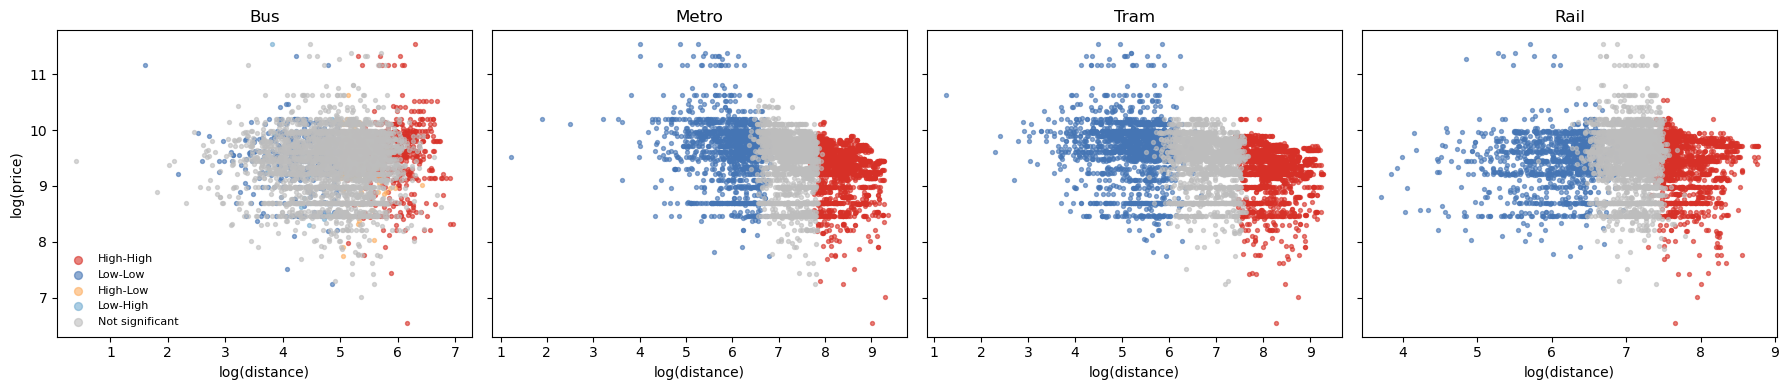

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

MODE_TO_LOGDIST = {
    "Bus":  "log_dist_bus_m",
    "Metro":"log_dist_metro_m",
    "Tram": "log_dist_tram_m",
    "Rail": "log_dist_rail_m",
}

CLUSTER_COLORS = {
    "High-High": "#d73027",
    "Low-Low": "#4575b4",
    "High-Low": "#fdae61",
    "Low-High": "#74add1",
    "Not significant": "#bdbdbd"
}

fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=True)

for ax, (mode, logdist_col) in zip(axes, MODE_TO_LOGDIST.items()):
    key = mode.lower()
    g = lisa_results[key]  # LISA subset (has index of price)

    # log(distance) from LISA results
    log_dist = g[logdist_col]

    # log(price) pulled from original price GeoDataFrame via index
    price_num = price.loc[g.index, "CENA_num"]
    log_price = np.log(price_num)

    cluster_col = f"lisa_cluster_{logdist_col}"
    clusters = g[cluster_col]

    for cl, color in CLUSTER_COLORS.items():
        mask = (
            (clusters == cl) &
            log_dist.notna() &
            log_price.notna()
        )

        ax.scatter(
            log_dist[mask],
            log_price[mask],
            s=8,
            alpha=0.6,
            c=color,
            label=cl
        )

    ax.set_title(mode)
    ax.set_xlabel("log(distance)")

axes[0].set_ylabel("log(price)")
axes[0].legend(markerscale=2, fontsize=8, frameon=False)

plt.tight_layout()
plt.show()


Scatter plots coloured by LISA cluster membership show that the distance–price relationship varies markedly across local spatial regimes, with tighter and more coherent patterns within high–high and low–low clusters and increased dispersion near regime boundaries.

The clear separation of observations into distinct LISA regimes produces a characteristic tricolour pattern, indicating that the distance–price relationship operates under different local spatial regimes rather than a single global trend.

C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


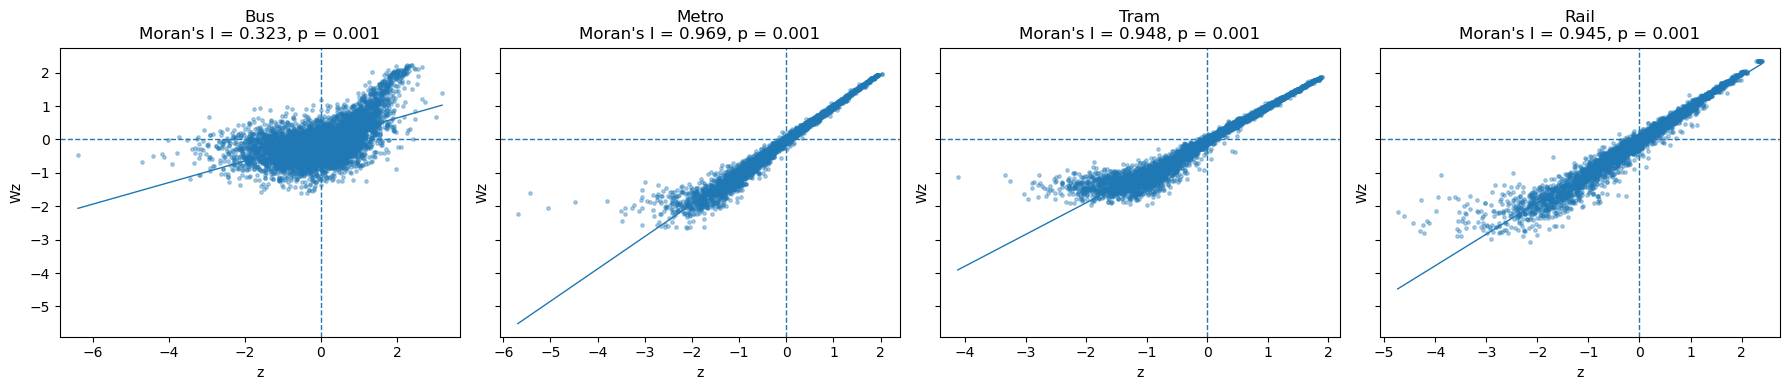

In [48]:

import numpy as np
import matplotlib.pyplot as plt
from esda.moran import Moran
from libpysal.weights.spatial_lag import lag_spatial

# --- 1) definuj proměnné (log-distance sloupce, co už máš ve výpočtech LISA) ---
DIST_LOG_COLS = {
    "Bus":  "log_dist_bus_m",
    "Metro":"log_dist_metro_m",
    "Tram": "log_dist_tram_m",
    "Rail": "log_dist_rail_m",
}

# pokud bys log sloupce neměl, dopočítej je (bezpečně)
for k, col in DIST_LOG_COLS.items():
    if col not in price.columns:
        raw = col.replace("log_", "")
        price[col] = np.log(pd.to_numeric(price[raw], errors="coerce"))

# --- 2) Moran plot helper ---
def moran_plot(ax, y, w, title="", point_size=6, alpha=0.35):
    """
    y: 1D array-like (bez NaN), w: weights odpovídající délce y (stejná dimenze)
    """
    # z-score standardizace (jako v klasickém Moran plotu)
    z = (y - y.mean()) / y.std(ddof=0)

    # spatial lag z
    wz = lag_spatial(w, z)

    # Moran I (pro popisek)
    mor = Moran(z, w, permutations=999)

    # scatter
    ax.scatter(z, wz, s=point_size, alpha=alpha)

    # osy v nule
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.axvline(0, linestyle="--", linewidth=1)

    # regresní přímka (vizuálně jako v reportu)
    b = np.polyfit(z, wz, 1)[0]
    xline = np.array([z.min(), z.max()])
    ax.plot(xline, b * xline, linewidth=1)

    ax.set_title(f"{title}\nMoran's I = {mor.I:.3f}, p = {mor.p_sim:.3f}")
    ax.set_xlabel("z")
    ax.set_ylabel("Wz")

    return mor

# --- 3) vytvoř 2x2 panel pro distance ---
fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=True)

morans = {}

for ax, (mode, col) in zip(axes, DIST_LOG_COLS.items()):
    # vezmeme jen finites
    y_all = price[col].astype(float).values
    mask = np.isfinite(y_all)

    # musí sedět dimenze y a w -> uděláme podmnožinu dat i vah
    # (libpysal W nemá .subset pro KNN, tak nejjednodušší je filtrovat gdf a w znovu sestavit)
    g_sub = price.loc[mask].copy()

    # weights znovu pro podmnožinu, ať sedí dimenze
    # IMPORTANT: g_sub už má CRS EPSG:5514 a centroidy implicitně z geometrie
    w_sub = KNN.from_dataframe(g_sub, k=8, use_index=True)
    w_sub.transform = "r"

    y = g_sub[col].values
    mor = moran_plot(ax, y, w_sub, title=mode, point_size=6, alpha=0.35)
    morans[mode] = mor

plt.tight_layout()
plt.show()


The Moran scatter plots further confirm that distance-based accessibility variables exhibit markedly different spatial structures across transport modes. 

Bus distance shows only moderate positive spatial autocorrelation, reflected in a relatively dispersed cloud of observations. This indicates that bus accessibility is spatially heterogeneous and locally variable, which is consistent with its role as a dense, area-covering service rather than a hierarchical network.

In contrast, metro, tram, and rail distances display very strong positive spatial autocorrelation, with observations closely aligned along the diagonal. 

This pattern implies a highly structured spatial process in which well-connected areas are predominantly surrounded by similarly well-connected areas, and poorly connected areas cluster together as well. 

The near absence of High–Low and Low–High quadrants highlights a polarized accessibility regime rather than gradual spatial transitions.

These results confirm that accessibility to rail-based transport modes is not spatially random and violates the assumption of independent observations. 

Consequently, global regression models are insufficient to capture these relationships, motivating the use of local spatial methods in the subsequent analysis.

In [52]:
lisa_results

{'price':       log_price                                           geometry  \
 1      8.480529  MULTIPOLYGON Z (((-746972.961 -1058097.797 0, ...   
 2      9.444622  MULTIPOLYGON Z (((-747150.551 -1056468.532 0, ...   
 3      7.012115  MULTIPOLYGON Z (((-748097.541 -1057567.507 0, ...   
 4      9.116030  MULTIPOLYGON Z (((-747923.471 -1057300.142 0, ...   
 6      9.444622  MULTIPOLYGON Z (((-747768.274 -1057238.397 0, ...   
 ...         ...                                                ...   
 5722   9.764800  MULTIPOLYGON Z (((-734358.586 -1035572.888 0, ...   
 5723   9.383453  MULTIPOLYGON Z (((-734165.405 -1035421.941 0, ...   
 5724   9.383453  MULTIPOLYGON Z (((-734270.85 -1035365.55 0, -7...   
 5725   9.383453  MULTIPOLYGON Z (((-734344.955 -1035177.357 0, ...   
 5727   9.383453  MULTIPOLYGON Z (((-734341.42 -1035141.9 0, -73...   
 
       lisa_I_log_price  lisa_p_log_price  lisa_q_log_price  \
 1             2.036989             0.002                 3   
 2         

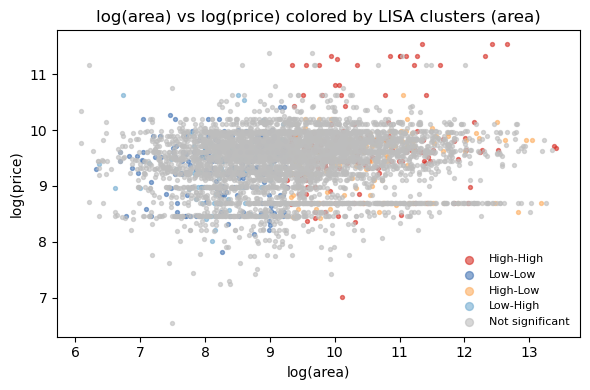

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# We color the area–price relationship by Local Moran (LISA) cluster classes computed on log(area).
# This lets us see whether the global association between size and price differs across locally
# coherent morphological zones (e.g., compact inner city vs suburban large-plot areas).

CLUSTER_COLORS = {
    "High-High": "#d73027",
    "Low-Low": "#4575b4",
    "High-Low": "#fdae61",
    "Low-High": "#74add1",
    "Not significant": "#bdbdbd"
}

g = lisa_results["area"]  # contains log_area and lisa_cluster_log_area

x = g["log_area"]  # log(area) from LISA table
price_num = price.loc[g.index, "CENA_num"]
y = np.log(price_num)     # log(price) from original GeoDataFrame

clusters = g["lisa_cluster_log_area"]

fig, ax = plt.subplots(figsize=(6, 4))

for cl, color in CLUSTER_COLORS.items():
    mask = (clusters == cl) & x.notna() & y.notna()
    ax.scatter(x[mask], y[mask], s=8, alpha=0.6, c=color, label=cl)

ax.set_xlabel("log(area)")
ax.set_ylabel("log(price)")
ax.set_title("log(area) vs log(price) colored by LISA clusters (area)")
ax.legend(markerscale=2, fontsize=8, frameon=False)

plt.tight_layout()
plt.show()


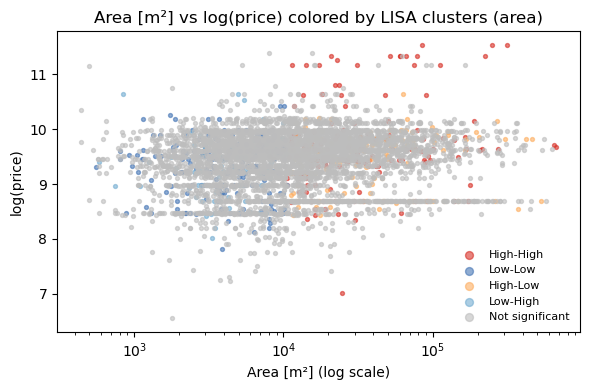

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Optional: plot area in m² instead of log(area). Use log-scale on x for readability.

g = lisa_results["area"]
x_m2 = np.exp(g["log_area"])
y = np.log(price.loc[g.index, "CENA_num"])
clusters = g["lisa_cluster_log_area"]

fig, ax = plt.subplots(figsize=(6, 4))

for cl, color in CLUSTER_COLORS.items():
    mask = (clusters == cl) & np.isfinite(x_m2) & y.notna()
    ax.scatter(x_m2[mask], y[mask], s=8, alpha=0.6, c=color, label=cl)

ax.set_xscale("log")
ax.set_xlabel("Area [m²] (log scale)")
ax.set_ylabel("log(price)")
ax.set_title("Area [m²] vs log(price) colored by LISA clusters (area)")
ax.legend(markerscale=2, fontsize=8, frameon=False)

plt.tight_layout()
plt.show()


#### Interpretation: Area vs Price with Local Spatial Context

The scatter plot shows the relationship between parcel size and land price, with observations colored by Local Moran (LISA) clusters computed on area.
In the baseline view, area alone explains only a limited share of price variation: prices remain widely dispersed across several orders of magnitude of parcel size.

Introducing LISA clusters reveals that spatial structure in area primarily reflects urban form rather than price formation.
High–High clusters (large parcels surrounded by large parcels) are concentrated at the upper end of the area distribution and correspond to peripheral or low-density zones, yet they do not consistently map to higher prices.
Conversely, Low–Low clusters (small parcels surrounded by small parcels) dominate compact inner-city areas, but again exhibit substantial price dispersion.

Overall, the weak stratification of prices across area-based LISA regimes suggests that parcel size captures morphological patterns, not economic valuation directly.



#### Moran plot of area

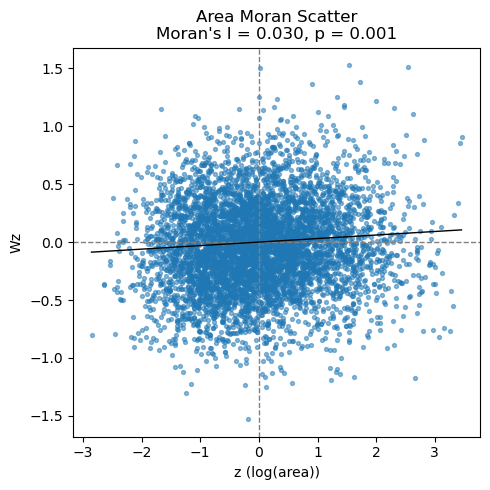

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from esda import Moran
from libpysal.weights.spatial_lag import lag_spatial

# LISA subset for area
g = lisa_results["area"]

# variable
x = g["log_area"].values
mask = np.isfinite(x)

# Moran's I
moran_area = Moran(x[mask], w, permutations=999)

# standardized values
z = moran_area.z

# spatial lag of z
wz = lag_spatial(w, z)

# plot
plt.figure(figsize=(5, 5))
plt.scatter(z, wz, s=8, alpha=0.5)

# reference lines
plt.axhline(0, linestyle="--", color="grey", linewidth=1)
plt.axvline(0, linestyle="--", color="grey", linewidth=1)

# regression line (slope = Moran's I)
x_vals = np.linspace(z.min(), z.max(), 100)
plt.plot(x_vals, moran_area.I * x_vals, color="black", linewidth=1)

plt.xlabel("z (log(area))")
plt.ylabel("Wz")
plt.title(
    f"Area Moran Scatter\nMoran's I = {moran_area.I:.3f}, p = {moran_area.p_sim:.3f}"
)

plt.tight_layout()
plt.show()


The Moran scatter plot for parcel area confirms a positive but moderate spatial autocorrelation, indicating that parcel sizes cluster locally but with substantially weaker spatial structure than transport accessibility measures.

This motivates shifting the focus from spatial autocorrelation in inputs (area, distances) to spatial autocorrelation in the dependent variable itself — price.

#### Moran Scatter Plot of Price
The Moran scatter plot evaluates global spatial autocorrelation in housing prices by relating standardized prices to their spatially lagged counterparts. 
A positive slope indicates that high-priced areas tend to be surrounded by other high-priced areas, and vice versa.

C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


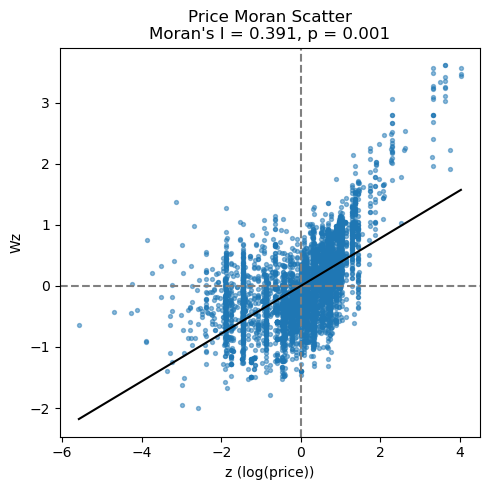

In [62]:
g_price = price[["CENA_num", "geometry"]].copy()
g_price["log_price"] = np.log(g_price["CENA_num"])

# drop NaNs
g_price = g_price[np.isfinite(g_price["log_price"])]

from libpysal.weights import KNN

w_price = KNN.from_dataframe(g_price, k=8)
w_price.transform = "r"

from esda import Moran
from libpysal.weights.spatial_lag import lag_spatial

y = g_price["log_price"].values

moran_price = Moran(y, w_price, permutations=999)

z = moran_price.z
wz = lag_spatial(w_price, z)

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 5))
plt.scatter(z, wz, s=8, alpha=0.5)

plt.axhline(0, linestyle="--", color="grey")
plt.axvline(0, linestyle="--", color="grey")

x_vals = np.linspace(z.min(), z.max(), 100)
plt.plot(x_vals, moran_price.I * x_vals, color="black")

plt.xlabel("z (log(price))")
plt.ylabel("Wz")
plt.title(
    f"Price Moran Scatter\nMoran's I = {moran_price.I:.3f}, p = {moran_price.p_sim:.3f}"
)

plt.tight_layout()
plt.show()





The Moran scatter plot for log-transformed  prices shows a clear positive spatial autocorrelation. 
        
The upward-sloping regression line and the concentration of observations in the High–High (upper right) and Low–Low (lower left) quadrants indicate that high-priced areas tend to be surrounded by other high-priced areas, while low-priced areas cluster near similarly low-priced neighborhoods.

The estimated Global Moran’s I = 0.391 (p = 0.001) confirms that this spatial clustering is statistically significant and unlikely to be the result of random spatial variation. 
    
This result provides strong evidence that housing prices are spatially structured, violating the assumption of spatial independence.

Consequently, spatial effects must be explicitly accounted for in subsequent modeling steps, either through spatial econometric specifications (e.g. spatial lag or spatial error models) or through locally adaptive approaches.

### Spatial distribution of local Moran I statistics

Spatial distribution of LISA clusters.

After confirming global spatial autocorrelation (Global Moran’s I), we inspect where clustering occurs using Local Moran (LISA). 

Each polygon is classified as High–High (high values surrounded by high values), Low–Low (low surrounded by low), or as spatial outliers (High–Low, Low–High). 

Polygons not significant at α=0.05 are shown in grey. 

Mapping these clusters helps interpret whether patterns are concentrated near the city center, along transport corridors, or in peripheral areas, and motivates moving from purely global models to spatially aware modelling.

#### Auxiliary plotting function

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from libpysal.weights import KNN
from esda.moran import Moran_Local

# Consistent cluster palette (same as before)
CLUSTER_COLORS = {
    "High-High": "#d73027",
    "Low-Low": "#4575b4",
    "High-Low": "#fdae61",
    "Low-High": "#74add1",
    "Not significant": "#bdbdbd",
}

CLUSTER_ORDER = ["High-High", "Low-Low", "High-Low", "Low-High", "Not significant"]

def compute_lisa_clusters(
    gdf: gpd.GeoDataFrame,
    value_col: str,
    k: int = 8,
    crs_m: str = "EPSG:5514",
    alpha: float = 0.05,
    permutations: int = 999,
):
    """
    Compute Local Moran (LISA) clusters for a single variable column.

    Returns:
      g_sub: GeoDataFrame subset used for LISA (no missing values)
      w_sub: KNN weights built on the same subset
    Side effects:
      Adds columns to g_sub:
        - lisa_I_<value_col>
        - lisa_p_<value_col>
        - lisa_q_<value_col>
        - lisa_cluster_<value_col>
    """

    # 1) Subset only valid observations (critical for matching dimensions with weights!)
    mask = np.isfinite(gdf[value_col].values)
    g_sub = gdf.loc[mask].copy()

    # 2) Project to a metric CRS so that KNN works in meters
    g_sub = g_sub.to_crs(crs_m)

    # 3) Build weights on the SAME subset
    w_sub = KNN.from_dataframe(g_sub, k=k, use_index=True)
    w_sub.transform = "r"

    # 4) Ensure y matches the internal order of weights
    y = g_sub[value_col].reindex(w_sub.id_order).values

    # 5) Local Moran
    lisa = Moran_Local(y, w_sub, permutations=permutations)

    # 6) Store raw LISA outputs
    g_sub[f"lisa_I_{value_col}"] = lisa.Is
    g_sub[f"lisa_p_{value_col}"] = lisa.p_sim
    g_sub[f"lisa_q_{value_col}"] = lisa.q
    g_sub[f"lisa_sig_{value_col}"] = lisa.p_sim < alpha

    # 7) Map quadrant codes -> cluster labels with significance filter
    sig = g_sub[f"lisa_sig_{value_col}"].values
    q = g_sub[f"lisa_q_{value_col}"].values

    cluster = np.array(["Not significant"] * len(g_sub), dtype=object)
    cluster[(sig) & (q == 1)] = "High-High"
    cluster[(sig) & (q == 2)] = "Low-High"
    cluster[(sig) & (q == 3)] = "Low-Low"
    cluster[(sig) & (q == 4)] = "High-Low"

    g_sub[f"lisa_cluster_{value_col}"] = pd.Categorical(cluster, categories=CLUSTER_ORDER, ordered=True)

    return g_sub, w_sub


def plot_lisa_cluster_map(
    g_sub: gpd.GeoDataFrame,
    cluster_col: str,
    title: str,
    figsize=(10, 8)
):
    """
    Plot LISA cluster categories on a map.
    """

    # Convert palette to category->color dict
    cmap = [CLUSTER_COLORS[c] for c in CLUSTER_ORDER]

    ax = g_sub.plot(
        column=cluster_col,
        categorical=True,
        legend=True,
        figsize=figsize,
        cmap=None,   # geopandas ignores cmap for categorical unless we pass color per category;
    )

    # Workaround: re-plot category-by-category so colors are exactly what we want
    plt.close()  # close the auto plot to avoid duplicates
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for cat in CLUSTER_ORDER:
        subset = g_sub[g_sub[cluster_col] == cat]
        subset.plot(ax=ax, color=CLUSTER_COLORS[cat], linewidth=0.0)

    ax.set_title(title)
    ax.set_axis_off()

    # Manual legend
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=CLUSTER_COLORS[c], label=c) for c in CLUSTER_ORDER]
    ax.legend(handles=handles, loc="lower left", frameon=False)

    plt.tight_layout()
    plt.show()


def plot_lisa_I_map(
    g_sub: gpd.GeoDataFrame,
    I_col: str,
    title: str,
    figsize=(10, 8)
):
    """
    Plot Local Moran's I values (continuous surface).
    """
    ax = g_sub.plot(
        column=I_col,
        legend=True,
        figsize=figsize
    )
    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


#### Spatial distribution of Local Moran I of Price

C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


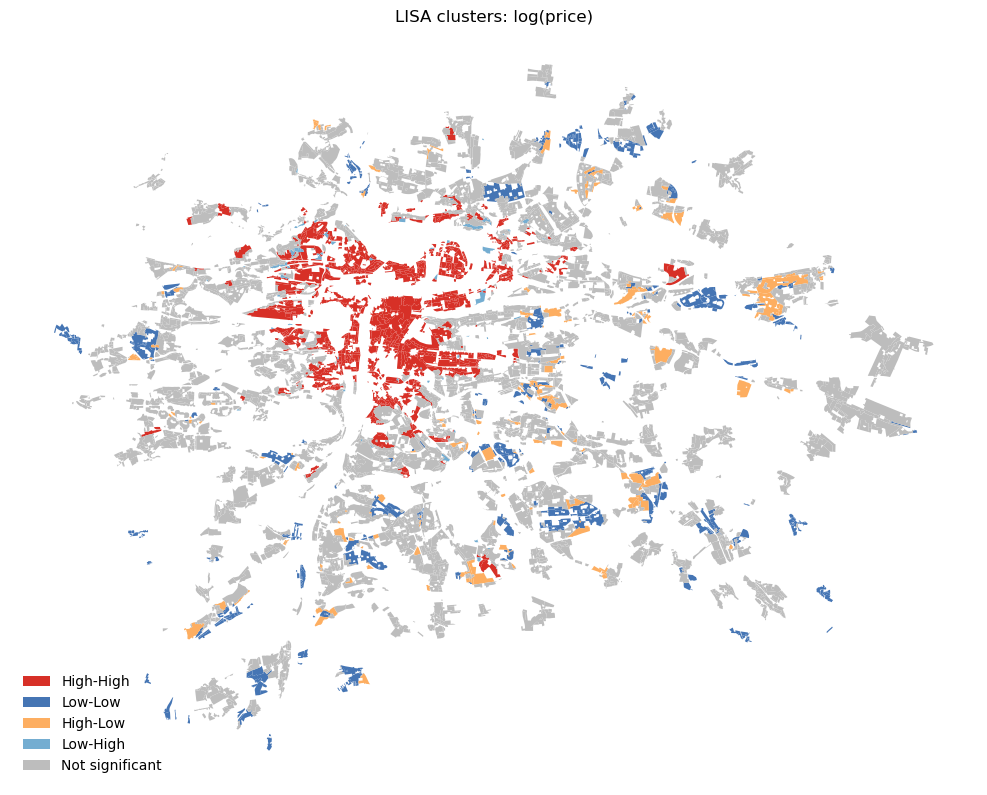

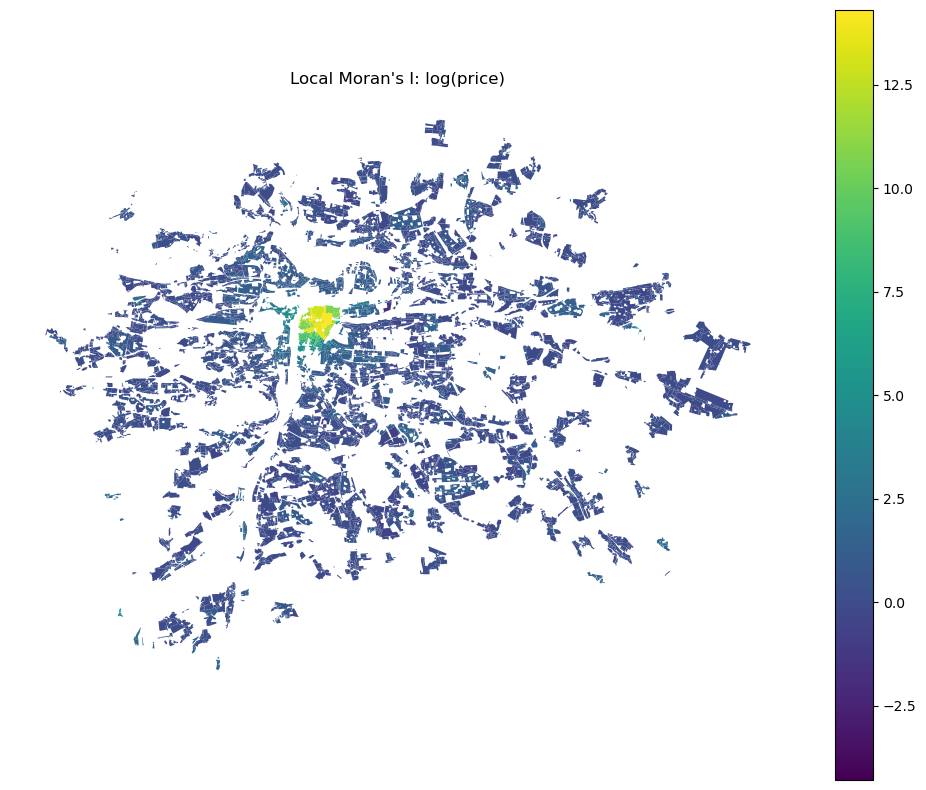

In [71]:
# --- Make sure these columns exist in your main 'price' GeoDataFrame:
# price["CENA_num"] numeric
# price["log_price"] = np.log(price["CENA_num"])

price = price.copy()
price["log_price"] = np.log(price["CENA_num"])

g_price, w_price = compute_lisa_clusters(price, "log_price", k=8)

plot_lisa_cluster_map(
    g_price,
    "lisa_cluster_log_price",
    "LISA clusters: log(price)"
)

plot_lisa_I_map(
    g_price,
    "lisa_I_log_price",
    "Local Moran's I: log(price)"
)


When investigating the spatial distribution of the local Moran statistic for land price, several clusters of high values neighbouring other high values can be observed. 

The most prominent cluster is located northwest of the city centre, corresponding to the Hanspaulka neighbourhood. This area is characterised by historical mansions and high-end residential development. 

Smaller high–high clusters in its vicinity consist primarily of historical villas offering direct views of Prague Castle, which further explains their similar spatial clustering pattern.

Another large high–high cluster is visible east of the Vltava River meander, in the Harfa neighbourhood, which contains newly built luxury penthouses.

In general, areas exhibiting high land prices surrounded by similarly high values tend to correspond either to historical mansion districts, luxury residential developments, or dense blocks of historical apartment buildings.

In contrast, large low–low clusters can be observed in the eastern part of the city. 

These polygons predominantly consist of large prefabricated concrete housing estates constructed during the socialist period. 

Although one isolated low–low polygon in the southern part of the city consists mainly of detached houses, its proximity to major highways and ring-road infrastructure, combined with the absence of nearby metro access, likely contributes to its lower price levels and corresponding Moran statistics.

#### Spatial distribution of Local Moran I of Area

C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


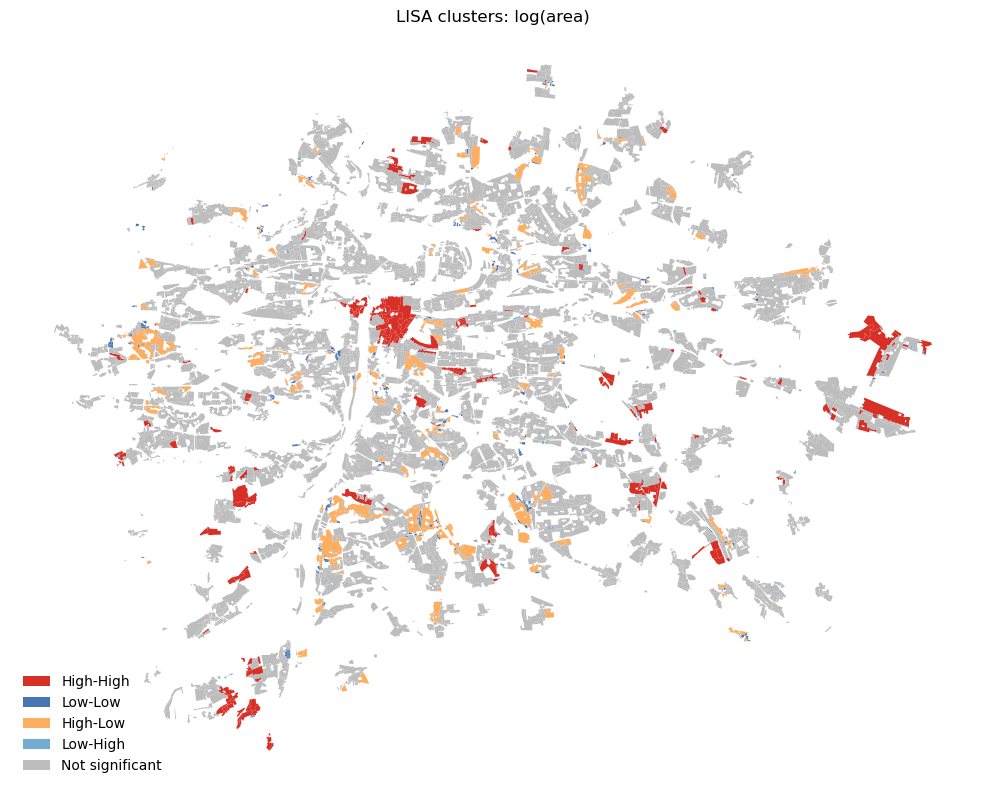

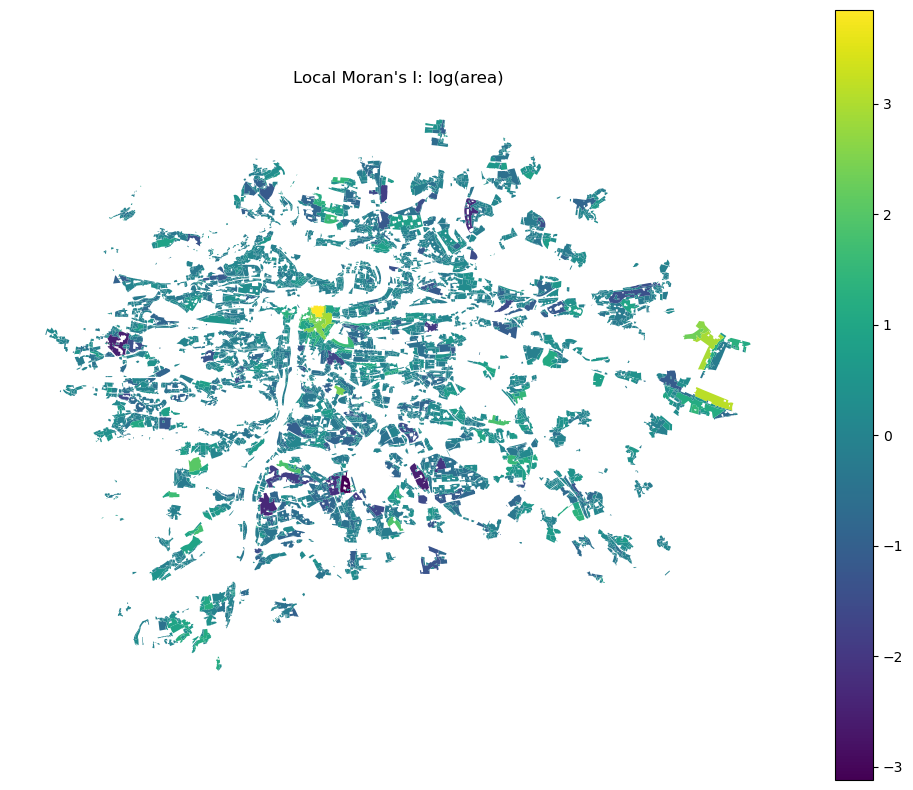

In [79]:
import numpy as np

# --- Prepare area for LISA on log(area) ---
# Assumes:
# - price["price_area"] exists and is numeric (area in m²)
# - geometry is already correct

price = price.copy()

# Robust log transform for area
price["log_area"] = np.where(
    np.isfinite(price["price_area"]) & (price["price_area"] > 0),
    np.log(price["price_area"]),
    np.nan
)

# Keep only valid observations
price_area_lisa = price.loc[price["log_area"].notna()].copy()

# --- Compute LISA clusters (KNN weights) ---
g_area, w_area = compute_lisa_clusters(
    price_area_lisa,
    value_col="log_area",
    k=8
)

# --- Plot outputs using helper functions ---
plot_lisa_cluster_map(
    g_area,
    cluster_col="lisa_cluster_log_area",
    title="LISA clusters: log(area)"
)

plot_lisa_I_map(
    g_area,
    I_col="lisa_I_log_area",
    title="Local Moran's I: log(area)"
)


Spatial distribution of Local Moran’s I for Area

The spatial distribution of Local Moran’s I for residential land area (log-transformed) reveals a markedly different clustering structure compared to price. 

High–High clusters (red polygons) are predominantly located on the outskirts of the city, where suburban development with detached houses and large gardens is dominant. 

These areas are characterized by relatively homogeneous parcel sizes, which naturally leads to positive spatial autocorrelation in land area.

In contrast, the city center exhibits only a limited number of statistically significant clusters. 

Where High–High clusters appear in central locations, they typically correspond to large historical apartment blocks or institutional residential complexes, whose parcel sizes stand out relative to their immediate surroundings. 

However, these clusters are spatially fragmented and do not form continuous zones, indicating that large-area parcels in the inner city are the exception rather than the norm.

Low–Low clusters (blue polygons) are sparse and spatially dispersed. 

This suggests that small residential parcels are not strongly clustered in space, which is consistent with the heterogeneous urban fabric of Prague, where small parcels coexist with larger developments even within short distances.

Overall, the dominance of non-significant polygons and the fragmented nature of significant clusters confirm that residential land area exhibits weaker and more localized spatial autocorrelation than price. 

This observation aligns with the Moran scatter plot results, where the relationship between standardized values and their spatial lag appears more diffuse, indicating that parcel size is less spatially structured than economic value.

#### Spatial distribution of Local Moran I of Distances

C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


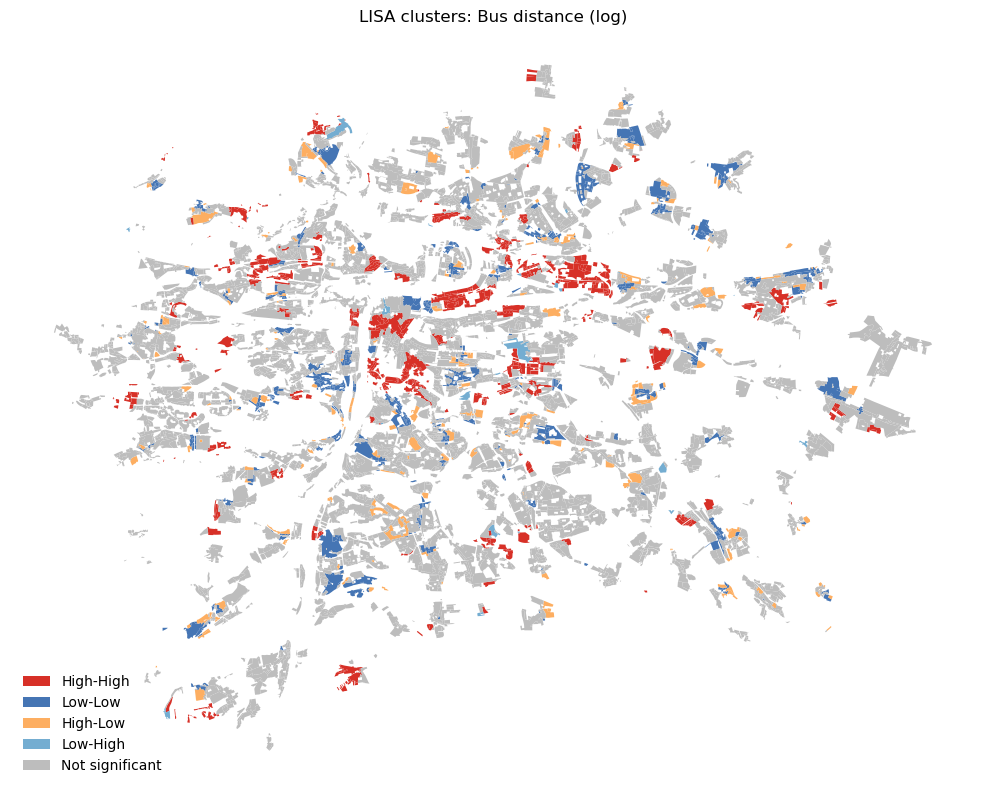

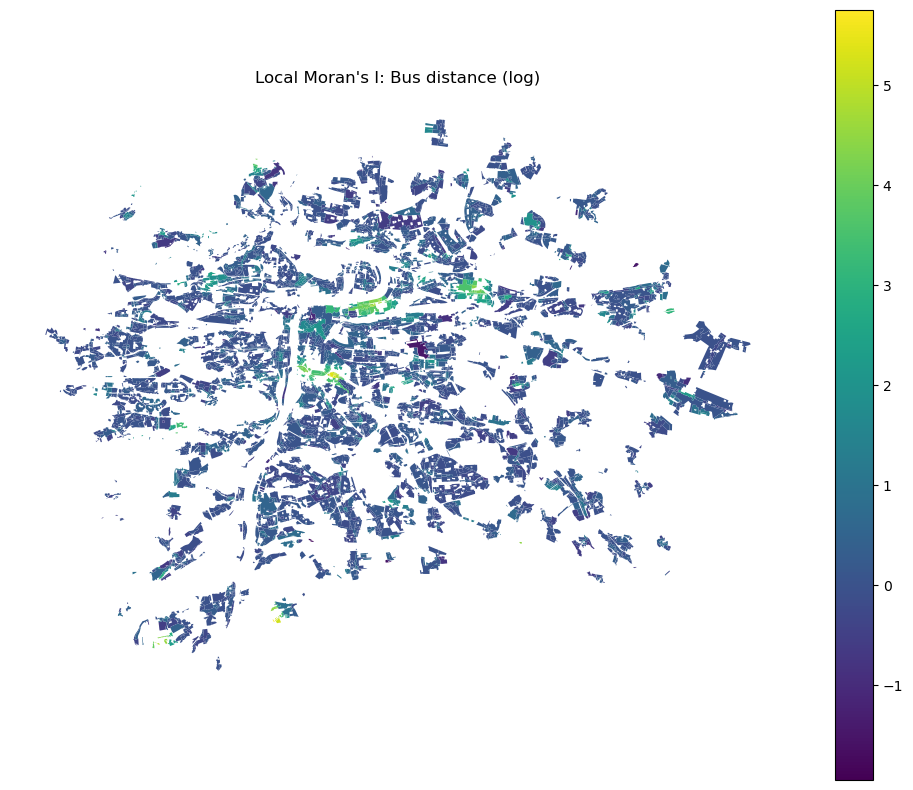

C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Vilem\AppData\Local\Temp\ipykernel_1440\4166491212.py:107: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(ax=ax, color=CLUSTER_COLORS[cat], linewidth=0.0)
C:\Users\Vilem\AppData\Local\Temp\ipykernel_1440\4166491212.py:107: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(ax=ax, color=CLUSTER_COLORS[cat], linewidth=0.0)


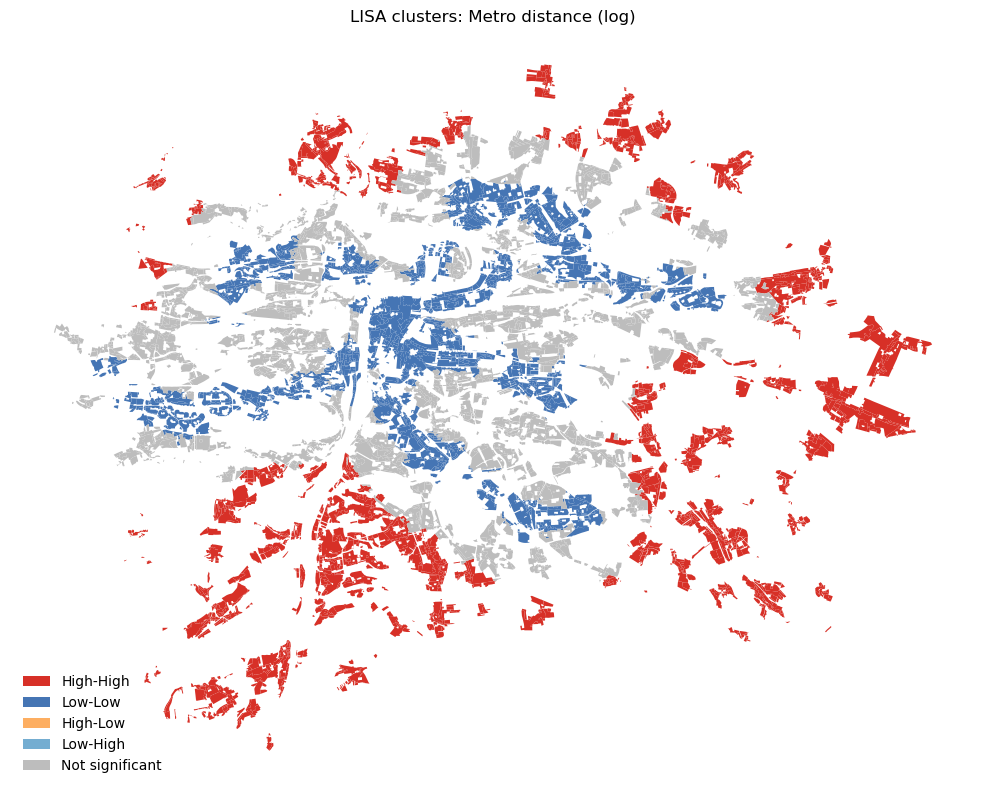

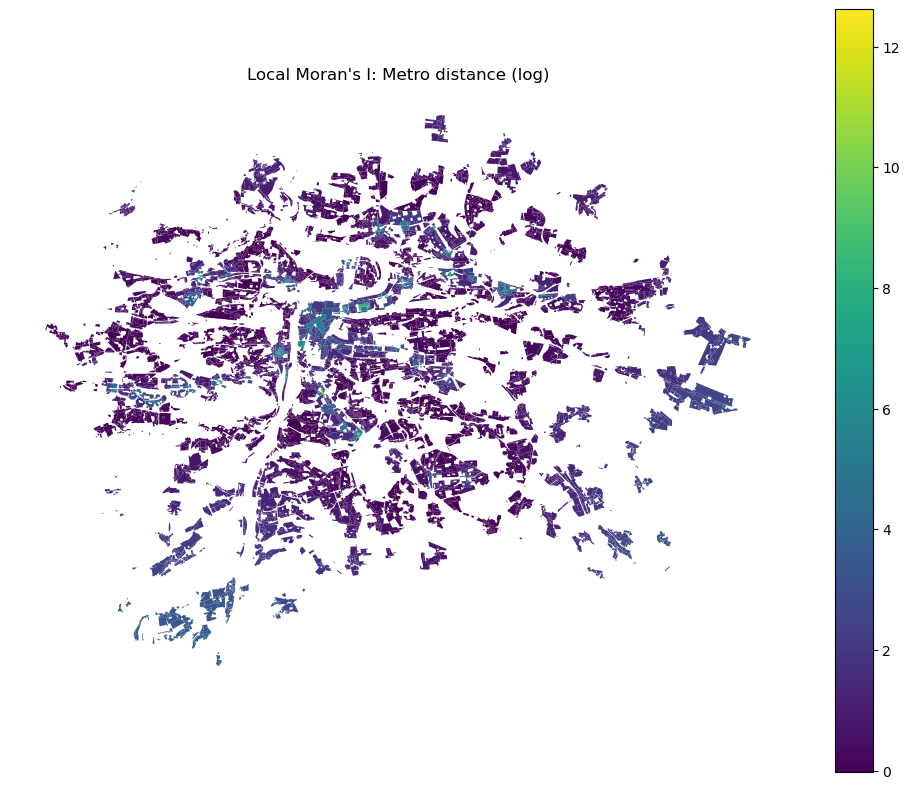

C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Vilem\AppData\Local\Temp\ipykernel_1440\4166491212.py:107: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(ax=ax, color=CLUSTER_COLORS[cat], linewidth=0.0)


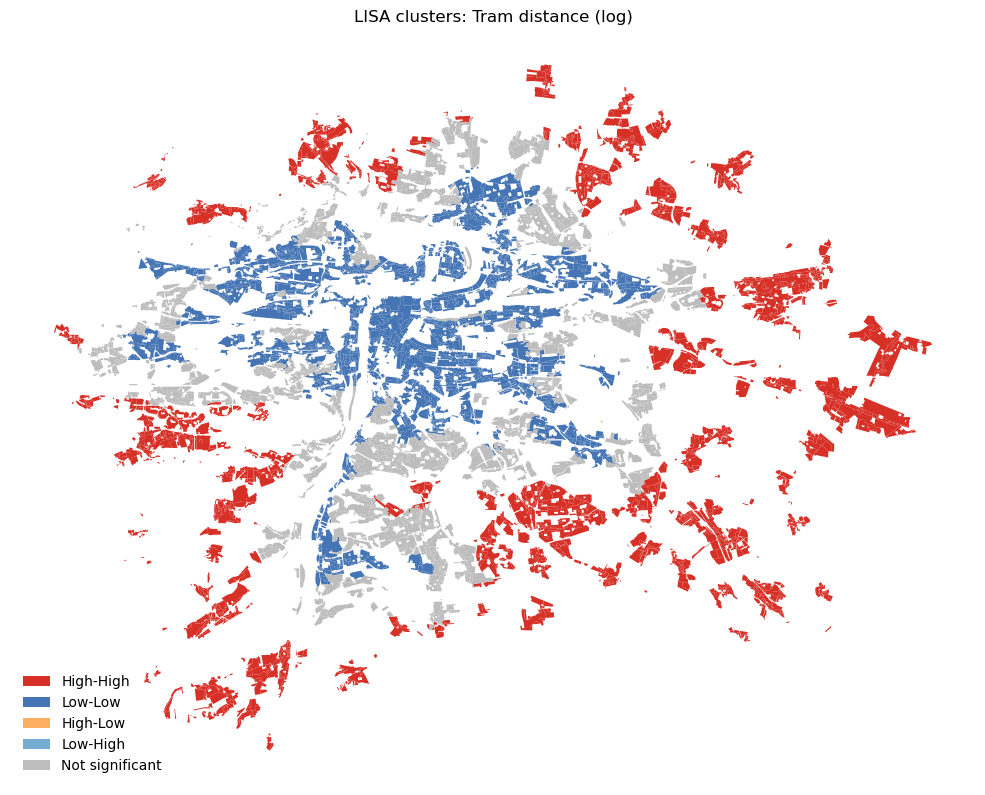

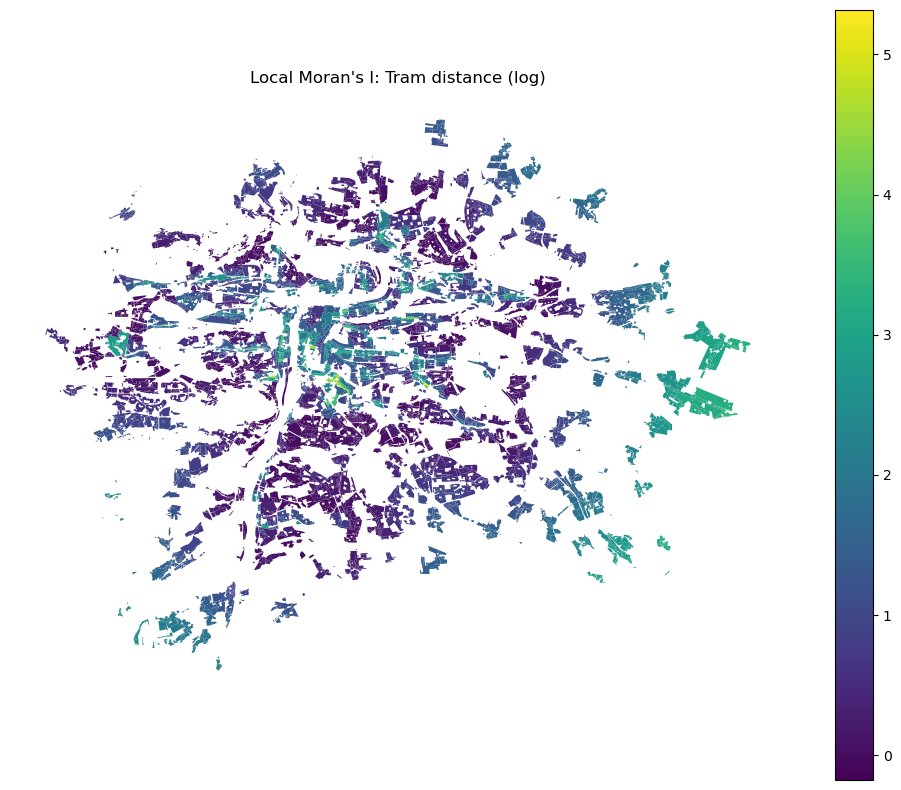

C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Vilem\AppData\Local\Temp\ipykernel_1440\4166491212.py:107: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(ax=ax, color=CLUSTER_COLORS[cat], linewidth=0.0)


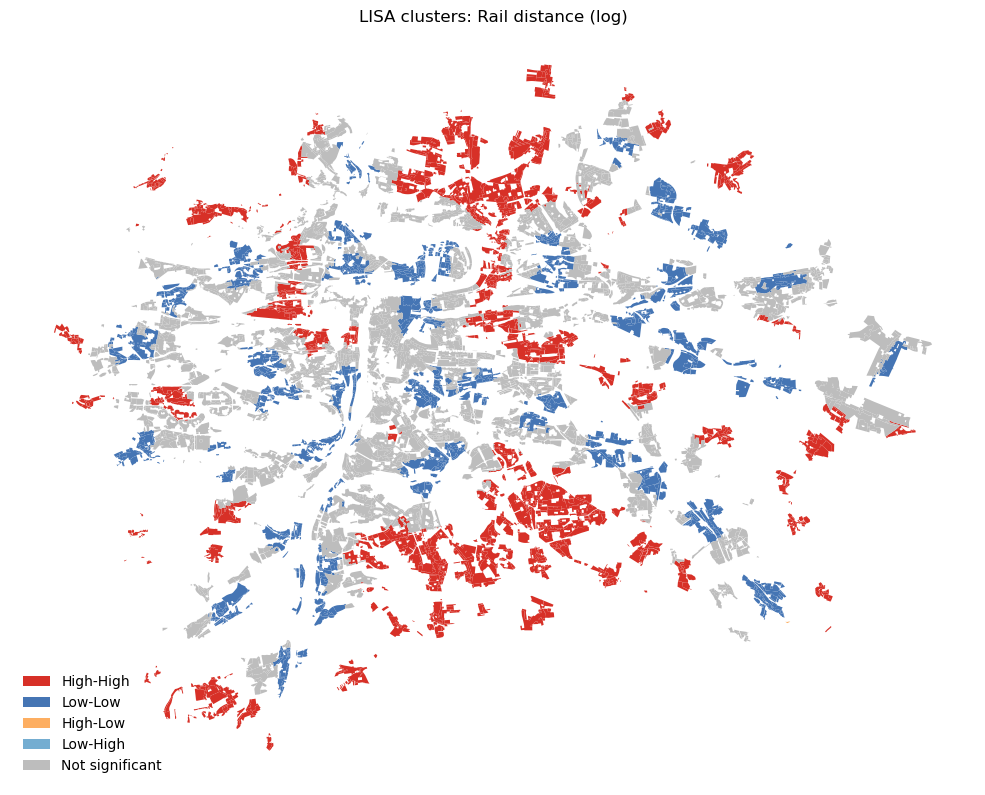

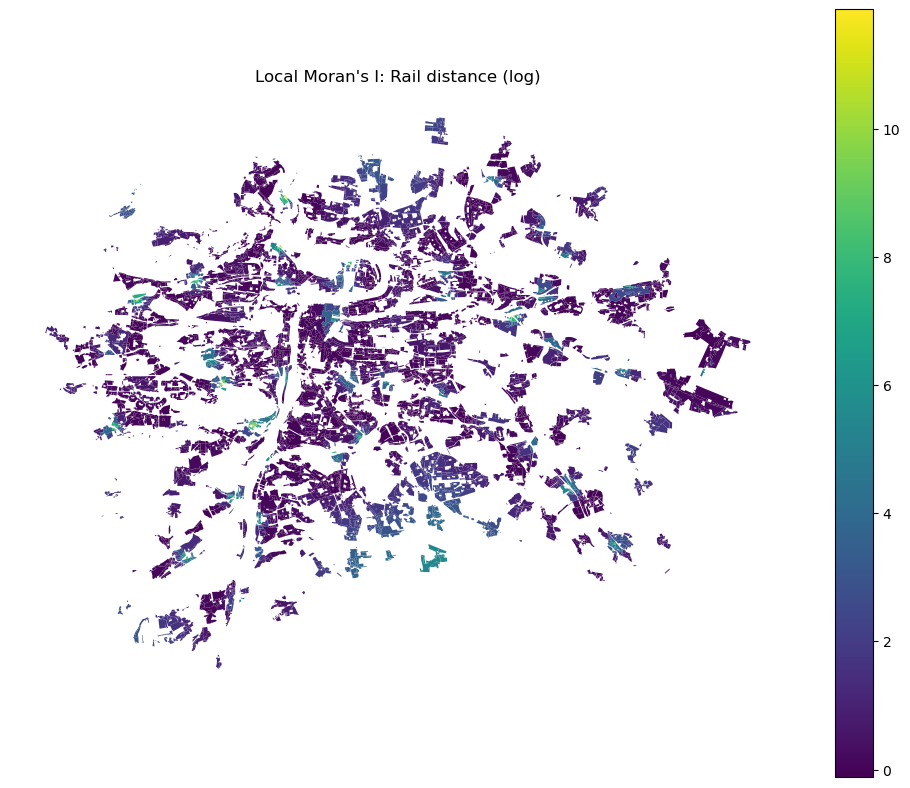

In [75]:
# Distances (already logged in your lisa_results): ensure they exist in 'price' as well
DIST_LOG_COLS = {
    "Bus":  "log_dist_bus_m",
    "Metro":"log_dist_metro_m",
    "Tram": "log_dist_tram_m",
    "Rail": "log_dist_rail_m",
}

for mode, col in DIST_LOG_COLS.items():
    g_mode, w_mode = compute_lisa_clusters(price, col, k=8)

    plot_lisa_cluster_map(
        g_mode,
        f"lisa_cluster_{col}",
        f"LISA clusters: {mode} distance (log)"
    )

    plot_lisa_I_map(
        g_mode,
        f"lisa_I_{col}",
        f"Local Moran's I: {mode} distance (log)"
    )


#### Summary of Local Spatial Autocorrelation by Transport Mode

**Price (log)**

Local Moran’s I for residential land prices reveals clear spatial clustering of high-value areas.

High–High clusters are concentrated in historically prestigious neighborhoods and newly developed luxury zones, while Low–Low clusters correspond to large housing estates and peripheral areas with lower attractiveness. 
    
This confirms that residential land prices in Prague exhibit strong and economically interpretable spatial dependence.

**Area (log)**

The spatial clustering of residential area sizes is considerably weaker and more fragmented. High–High clusters appear mainly in suburban zones characterized by detached housing with large plots, whereas the city center is dominated by mixed or insignificant clusters. 

The absence of extensive Low–Low clustering suggests that residential plot sizes are spatially heterogeneous and less systematically structured than prices.

**Bus distance (log)**

Local Moran’s I for bus accessibility shows a fine-grained and heterogeneous spatial pattern. Many Low–Low clusters indicate well-served areas with dense bus networks, often adjacent to less accessible neighborhoods. 

This reflects the flexible and historically adaptive nature of bus services, which tend to smooth local accessibility gaps rather than impose a strong global spatial structure.

**Metro distance (log)**

Metro accessibility exhibits a strong and highly structured spatial pattern. Low–Low clusters closely follow existing metro lines, forming continuous corridors of high accessibility, while High–High clusters dominate the outer parts of the city beyond the metro network. 

This clear inner–outer contrast highlights the metro system as a primary driver of large-scale spatial accessibility gradients.

**Tram distance (log)**

The tram network produces a spatial pattern similar to the metro but with a denser inner-city coverage. 

Low–Low clusters dominate central and inner residential areas, indicating uniformly good tram accessibility, while High–High clusters are concentrated in peripheral neighborhoods where tram extensions are absent. 

The results reflect the historical stability of the tram network and its limited recent expansion toward the outskirts.

**Rail distance (log)**

Rail accessibility forms a corridor-based spatial structure. 

Low–Low clusters align along major railway lines radiating from the city center, while High–High clusters occupy the spaces between corridors. 

This pattern reflects the commuter-oriented design of the rail network and suggests that rail accessibility influences land prices in a spatially anisotropic and highly localized manner.


### Summary of Exploratory Spatial Analysis

This notebook focused on exploratory spatial analysis of residential land prices and transport accessibility in Prague, with the explicit goal of identifying whether spatial structure is present and whether it is strong enough to justify spatial modeling.

The analysis began with non-spatial exploratory data analysis, including scatter plots between land prices and accessibility measures (distance to bus, metro, tram, and rail stops), as well as residential land area. These plots suggested non-linear relationships, scale effects, and substantial heterogeneity that could not be fully explained in a purely aspatial framework.

To explicitly account for spatial structure, spatial weight matrices based on k-nearest neighbors were constructed and used to compute Global Moran’s I statistics. The results showed statistically significant positive spatial autocorrelation for land prices and for all transport accessibility variables, with particularly strong autocorrelation for metro, tram, and rail distances. This confirmed that similar values tend to cluster in space and that spatial dependence is a core property of the data.

Local Indicators of Spatial Association (LISA) were then computed to investigate where these spatial patterns occur. LISA cluster maps revealed coherent High–High and Low–Low clusters for prices, land area, and accessibility measures, as well as meaningful High–Low and Low–High transition zones. These clusters correspond closely to known urban structures such as historical villa neighborhoods, dense inner-city apartment areas, suburban developments, and transport corridors.

Scatter plots colored by LISA cluster membership further demonstrated that the observed price–accessibility relationships differ systematically across spatial regimes. The presence of clear cluster separation indicates that the marginal effect of accessibility is spatially heterogeneous and cannot be captured adequately by a single global coefficient.

Overall, the exploratory analysis provides strong empirical evidence that spatial autocorrelation and spatial heterogeneity are intrinsic features of the data. This implies that standard OLS regression assumptions are violated and motivates the transition to explicit spatial econometric and spatially varying coefficient models. For this reason, the next notebook is dedicated exclusively to spatial modeling, building directly on the spatial structures identified here.